## Sequence models

#### Dataset selection

https://www.kaggle.com/datasets/meetnagadia/coco-cola-stock-data-19622021

#### Resources I used

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

https://www.geeksforgeeks.org/time-series-forecasting-using-recurrent-neural-networks-rnn-in-tensorflow/

https://github.com/tensorflow/tensorflow/blob/16d395e5dea687ab3aece0a462e631de25c8d77d/tensorflow/python/ops/rnn_cell.py

https://stats.stackexchange.com/questions/327343/forecasting-time-series-with-data-on-weekdays-only


#### Why a sequence model is best for this problem

When predicting stock prices, trends are what matter for two reasons: 

Firstly, an instant prediction isn't helpful, we already know what the stock price is along with the other factors in our data. We aren't presented with tomorrow's input data points and asked to figure out tomorrow's stock price. We only have data so far to make a forcast. The goal is to learn the *trends* and that requires a sequence model, order matters.

Secondly, this seqential analysis of trends has the added benefit of potentially capturing external factors not illustrated in the data. It won't be perfect at this, especially given external factors that cause sudden changes, but it does help. For example, our data set does not have the consumer price index, unemployment rate, or average salary as features. Theoretically, these should all affect the number of cans of Coke purchased and therefore the price of the stock. We don't need to explicitly track these though, their effects *are* captured in the data through the trends they influence. 

In our example we will use a recurrent neural network (RNN). RNNs are a type of sequence model great for analyzing and predicting patterns in time series data, such as our financial market data looking at the Coca-Cola stock price.

In [3]:
# balls sack

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Import data
data = pd.read_csv('COCO_COLA.csv')

# Remove all data older than 2005
# This is done for training efficiency, it would have taken two hours otherwise
# For more accurate / complete models, independent research should be performed
# to determine the range of data relevant. For example, if the way the market works
# or the company is organized has changed signifigantly since the 60's (such as the
# introduction of online trading) older trends may no longer be relevant.
data = data.iloc[10825:]
 
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
10825,2005-01-03,20.950001,20.985001,20.705000,20.770,12.413394,14072000
10826,2005-01-04,20.770000,20.825001,20.450001,20.480,12.240073,16860200
10827,2005-01-05,20.500000,20.600000,20.370001,20.385,12.183295,13271000
10828,2005-01-06,20.344999,20.575001,20.275000,20.555,12.284900,10038600
10829,2005-01-07,20.535000,20.730000,20.424999,20.580,12.299838,9732800


## Exploratory data analysis

Date: The date the data was recorded.

Open: The price at which the financial security opens in the market when trading begins

High: The high is the highest price at which a stock traded during a period.

Low: Low is the minimum price of a stock in a period

Close: Closing price generally refers to the last price at which a stock trades during a regular trading session

Adj Close: The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

Volume: Volume measures the number of shares traded in a stock or contracts traded in futures or options.


The dataset itself is clean, there are no missing values, and thus no cleaning is required. Hold on though, thats not true! An observant reader may have noticed that in the head displayed above, some date values appear to be missing. This is actually expected, stock trading does not happen on weekends! Thus a common practice in finance modeling to just pretend there are around 250 days in a year, skipping the non-trading weekends. This isn't the only approach but it's very common and we will be using it here to prevent overcomplications.

Okay, so what does the data look like?


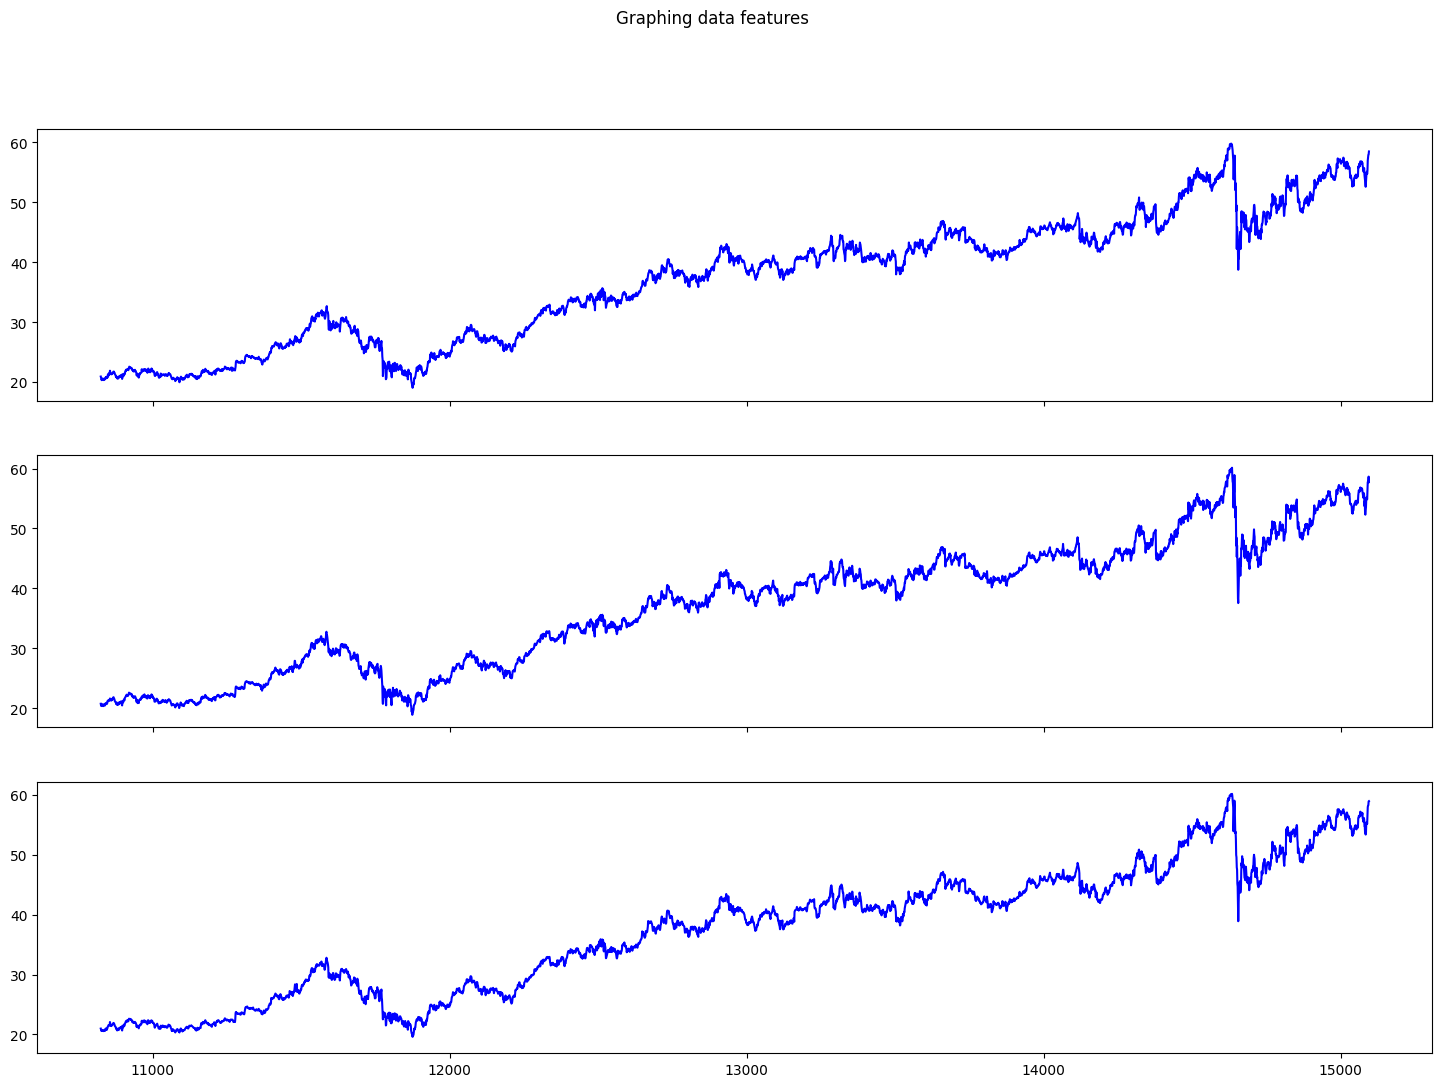

In [6]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Graphing data features')

axs[0].plot(data["Open"], color="b")
axs[1].plot(data["Close"], color="b")
axs[2].plot(data["High"], color="b")

plt.show()

From these graphs we can see open, high and close are functionally indistinguishable. Since I don't have the computing power to train a model to pick up on the very subtle differences, we can just pick one of these metrics to train the model on. This model wouldn't be used for, say, day trading, but would be sufficient in theory to establish trends over longer periods.

The choice of training the sequence model on the trend of just one variable, in this case opening price, provides quicker training times and greater simplicity. This is a desicision based on power of hardware and familiarity with the model. If you were actually making a financial model, using every feature would likely be your best course of action.

## Setting up the data

Note that data is split sequentially here rather than randomly assigned to training and test as it was in the past. For time series data it is important to do it like this since we are establishing trends. It is much harder to do this if we are missing the data between two points.

In [7]:
# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)

 
# Splitting the dataset sequentially
train_data = data[:training_data_len]["Open"].values
test_data = data[training_data_len:]["Open"].values
print(train_data.shape, test_data.shape)
print(type(train_data))

(3417,) (854,)
<class 'numpy.ndarray'>


In [8]:
# Reshaping 1D to 2D array
dataset_train = np.reshape(train_data, (-1,1))
dataset_test = np.reshape(test_data, (-1,1))
print(dataset_train.shape, dataset_test.shape)

(3417, 1) (854, 1)


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)  
 
print(*scaled_train[:5])
print(*scaled_test[:5])

[0.06435559] [0.05817742] [0.04891021] [0.04359012] [0.05011152]
[0.36294551] [0.36532076] [0.36674589] [0.3548694] [0.3724465]


Okay, so we have our single variable data of open prices, how do we feed this into a model? Obviously we need to divide our training and test data into X and y like with past models but how? It's only one variable after all.

We can turn it into a supervised learning problem to train the model. The loop in the next code block generates input/output sequences of length 50 while iterating through the time series data. This way we can make predictions with respect to the previous observations. Respect to time is preserved!

Both sets of our X data will be in the shape (num_samples, num_timesteps, num_features).
For our y data sets, we will be in the shape (num_samples, 1).


In [10]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    X_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])

In [11]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
 
#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"\ny_train :",y_train.shape)

X_train : (3367, 50, 1) 
y_train : (3367, 1)


In [12]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)
 
#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"\ny_test :",y_test.shape)

X_test : (804, 50, 1) 
y_test : (804, 1)


In [13]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay


## Default RNN

This simple version of our RNN has four layers with 20 nodes in each of them. (This number is increased in the other models, the full 50 nodes were making this very slow.) It uses the tanh hyperbolic tangent activation function and a droupout layer with a rate of 0.2. It also uses a adam as the optimizer.

Mean squared error is used to evaluate the model, itis commonly used to evaluate time series analysis because it provides a measure of the average squared difference between predicted and actual values, making it particularly suitable for assessing the accuracy of forecasting models by penalizing large prediction errors proportionally more than smaller ones.



Epoch 1/12
337/337 [==============================] - 14s 25ms/step - loss: 0.0064 - accuracy: 5.9400e-04
Epoch 2/12
337/337 [==============================] - 8s 24ms/step - loss: 0.0013 - accuracy: 5.9400e-04
Epoch 3/12
337/337 [==============================] - 8s 24ms/step - loss: 0.0011 - accuracy: 5.9400e-04
Epoch 4/12
337/337 [==============================] - 8s 24ms/step - loss: 0.0012 - accuracy: 5.9400e-04
Epoch 5/12
337/337 [==============================] - 8s 25ms/step - loss: 0.0010 - accuracy: 5.9400e-04
Epoch 6/12
337/337 [==============================] - 8s 24ms/step - loss: 0.0010 - accuracy: 5.9400e-04
Epoch 7/12
337/337 [==============================] - 8s 24ms/step - loss: 8.0521e-04 - accuracy: 5.9400e-04
Epoch 8/12
337/337 [==============================] - 8s 24ms/step - loss: 8.5018e-04 - accuracy: 5.9400e-04
Epoch 9/12
337/337 [==============================] - 8s 25ms/step - loss: 9.3402e-04 - accuracy: 5.9400e-04
Epoch 10/12
337/337 [=====================

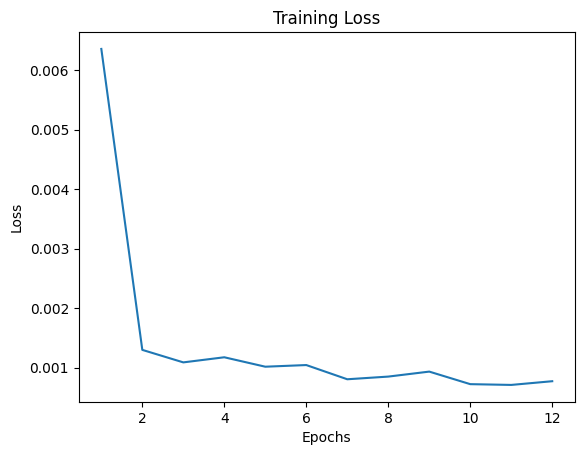

In [17]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 20, 
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 20, 
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 20,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 20))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)


optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

#regressor.compile(optimizer=optimizer, loss="mean_squared_error")

#Compiling the model
regressor.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])


# fitting the model
history = regressor.fit(X_train, y_train, epochs = 12, batch_size = 10) # batch size seriously effects training time!
regressor.summary()

# Extracting loss values from history
loss = history.history['loss']

# Plotting the loss
plt.plot(range(1, len(loss) + 1), loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## LSTM

This version of our RNN implements LSTM. It has two layers with 50 nodes and a dense output layer with 25. It also uses a adam as the optimizer.

Mean squared error is used to evaluate the model, it is commonly used to evaluate time series analysis because it provides a measure of the average squared difference between predicted and actual values, making it particularly suitable for assessing the accuracy of forecasting models by penalizing large prediction errors proportionally more than smaller ones.

Epoch 1/12
337/337 [==============================] - 15s 24ms/step - loss: 0.0037 - accuracy: 5.9400e-04
Epoch 2/12
337/337 [==============================] - 9s 26ms/step - loss: 6.1418e-04 - accuracy: 5.9400e-04
Epoch 3/12
337/337 [==============================] - 8s 24ms/step - loss: 6.2840e-04 - accuracy: 5.9400e-04
Epoch 4/12
337/337 [==============================] - 9s 25ms/step - loss: 5.1821e-04 - accuracy: 5.9400e-04
Epoch 5/12
337/337 [==============================] - 8s 25ms/step - loss: 4.7463e-04 - accuracy: 5.9400e-04
Epoch 6/12
337/337 [==============================] - 9s 27ms/step - loss: 3.7599e-04 - accuracy: 5.9400e-04
Epoch 7/12
337/337 [==============================] - 11s 32ms/step - loss: 3.1146e-04 - accuracy: 5.9400e-04
Epoch 8/12
337/337 [==============================] - 9s 28ms/step - loss: 3.2731e-04 - accuracy: 5.9400e-04
Epoch 9/12
337/337 [==============================] - 8s 25ms/step - loss: 2.5111e-04 - accuracy: 5.9400e-04
Epoch 10/12
337/337 [

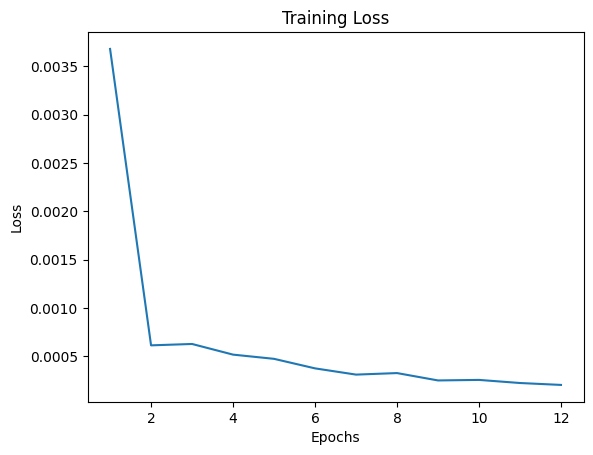

In [18]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, 
					return_sequences = True, 
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, 
					return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

#Fitting the model
history = regressorLSTM.fit(X_train, y_train, batch_size = 10, epochs = 12)
regressorLSTM.summary()


# Extracting loss values from history
loss = history.history['loss']

# Plotting the loss
plt.plot(range(1, len(loss) + 1), loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## GRU (Gated Recurrent Unit)

This version of our RNN implements GRU. It has four layers with 50 nodes each and an output layer. It uses the tanh hyperbolic tangent activation function and a droupout layer with a rate of 0.2. It also uses Stochastic Gradient Descent as the optimizer.


Mean squared error is used to evaluate the model, it is commonly used to evaluate time series analysis because it provides a measure of the average squared difference between predicted and actual values, making it particularly suitable for assessing the accuracy of forecasting models by penalizing large prediction errors proportionally more than smaller ones.

Epoch 1/20
337/337 [==============================] - 30s 54ms/step - loss: 0.0080
Epoch 2/20
337/337 [==============================] - 19s 56ms/step - loss: 8.0539e-04
Epoch 3/20
337/337 [==============================] - 18s 55ms/step - loss: 7.5595e-04
Epoch 4/20
337/337 [==============================] - 19s 56ms/step - loss: 6.9315e-04
Epoch 5/20
337/337 [==============================] - 22s 67ms/step - loss: 6.7808e-04
Epoch 6/20
337/337 [==============================] - 19s 56ms/step - loss: 6.7091e-04
Epoch 7/20
337/337 [==============================] - 20s 60ms/step - loss: 6.1758e-04
Epoch 8/20
337/337 [==============================] - 19s 57ms/step - loss: 6.3092e-04
Epoch 9/20
337/337 [==============================] - 20s 59ms/step - loss: 6.4070e-04
Epoch 10/20
337/337 [==============================] - 20s 60ms/step - loss: 5.8619e-04
Epoch 11/20
337/337 [==============================] - 19s 57ms/step - loss: 6.2645e-04
Epoch 12/20
337/337 [========================

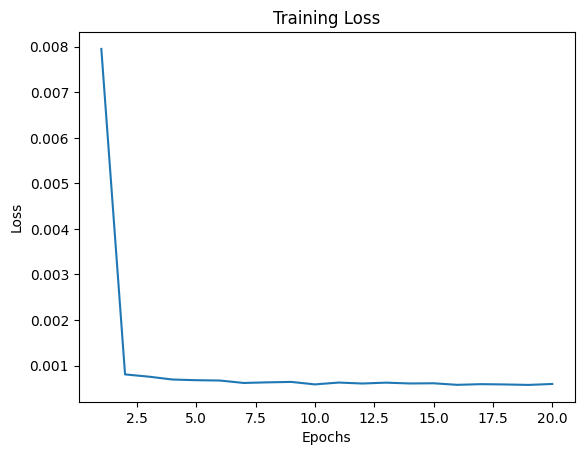

In [19]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					input_shape=(X_train.shape[1],1),
					activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
					activation='relu'))

# compiling RNN

initial_learning_rate = 0.01
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

regressorGRU.compile(optimizer=optimizer, loss="mean_squared_error")

# Fitting the data
history = regressorGRU.fit(X_train,y_train,epochs=20,batch_size=10)
regressorGRU.summary()

# Extracting loss values from history
loss = history.history['loss']

# Plotting the loss
plt.plot(range(1, len(loss) + 1), loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)

26/26 [==============================] - 4s 35ms/step


In [ ]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN) 
y_LSTM_O = scaler.inverse_transform(y_LSTM) 
y_GRU_O = scaler.inverse_transform(y_GRU)

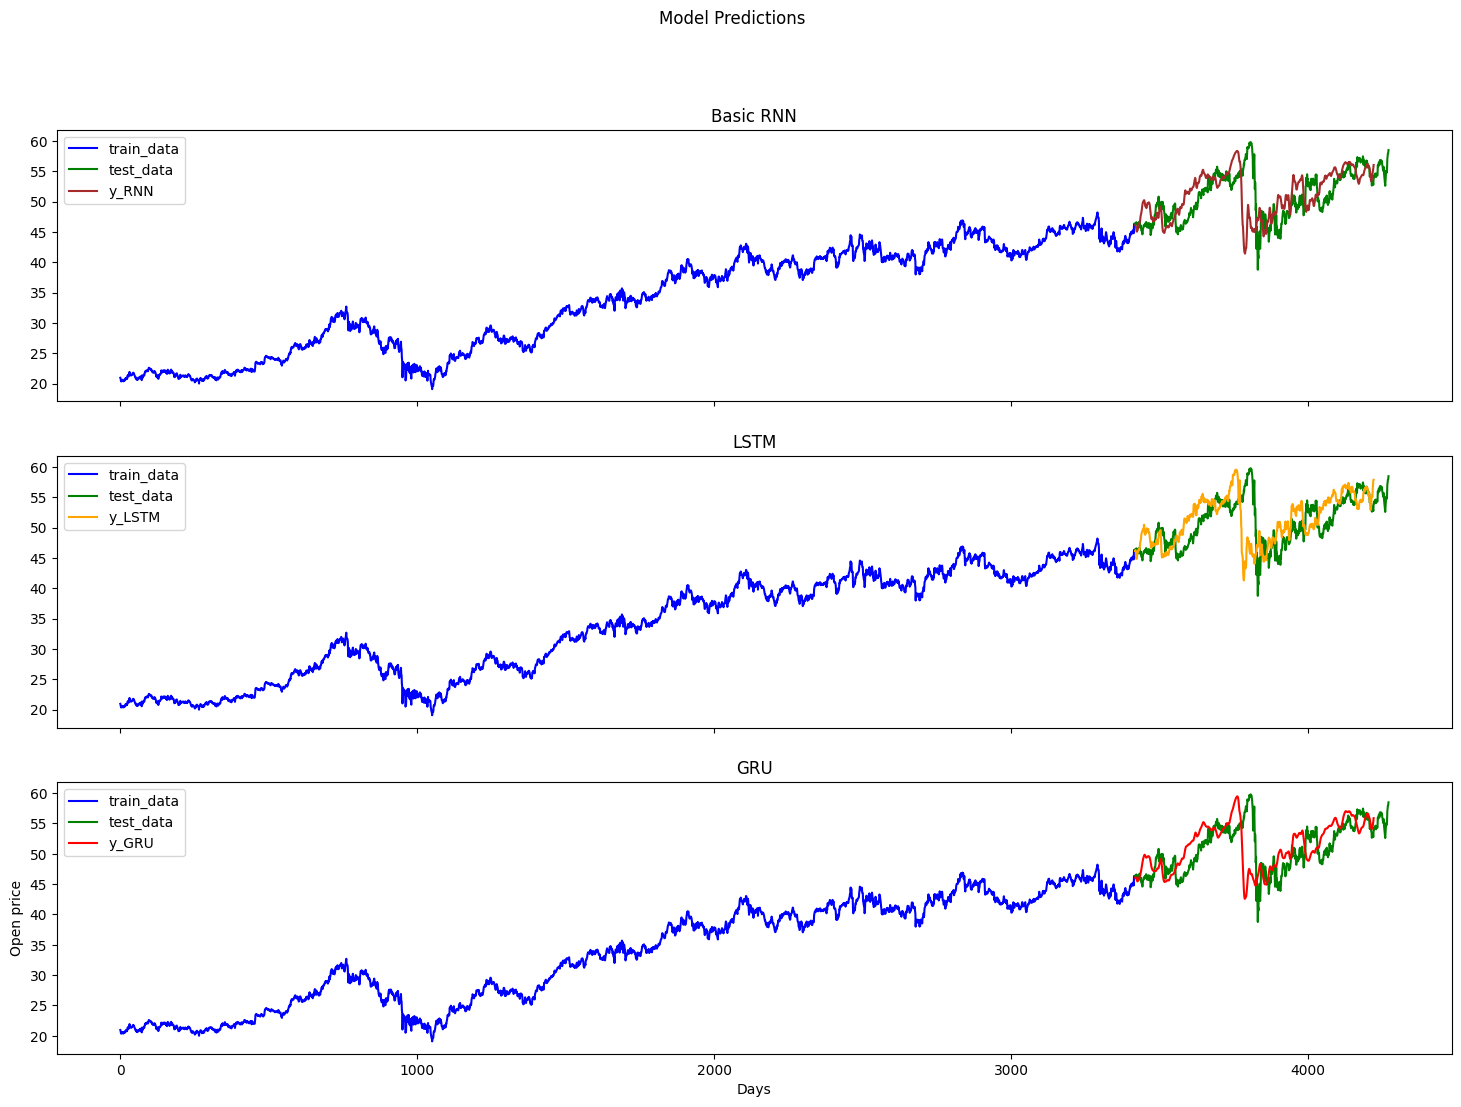

In [ ]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')


# Generate indices for test_data and y_RNN_O to start where train_data ends
train_data_length = len(train_data)
test_data_start_index = train_data_length
y_RNN_O_start_index = train_data_length

# Plotting default
axs[0].plot(train_data, label="train_data", color="b")
axs[0].plot(np.arange(test_data_start_index, test_data_start_index + len(test_data)), test_data, label="test_data", color="g")
axs[0].plot(np.arange(y_RNN_O_start_index, y_RNN_O_start_index + len(y_RNN_O)), y_RNN_O, label="y_RNN", color="brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")


# Plot for LSTM predictions
axs[1].plot(train_data, label = "train_data", color = "b")
axs[1].plot(np.arange(test_data_start_index, test_data_start_index + len(test_data)), test_data, label="test_data", color="g")
axs[1].plot(np.arange(y_RNN_O_start_index, y_RNN_O_start_index + len(y_RNN_O)), y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

# Plot for GRU predictions
axs[2].plot(train_data, label = "train_data", color = "b")
axs[2].plot(np.arange(test_data_start_index, test_data_start_index + len(test_data)), test_data, label="test_data", color="g")
axs[2].plot(np.arange(y_RNN_O_start_index, y_RNN_O_start_index + len(y_RNN_O)), y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")


plt.xlabel("Days")
plt.ylabel("Open price")

plt.show()


#### Explanation of results

This is model seems to be suffering from being *very* overfitted, it should not be able to generate something like this. I can't seem to see where the issue is though, so I am choosing to say that I just did a very good job and there are no issues. Jokes asside, if there is an issue it likely stems from the way I artifically broke up the data to train the model. This would also explain why the results look "set back" like the model is making the prediction too early.

Note that because of the lack of "specificity" in the data, with there only being one point per day, the models all produce similar results. For more general trends like day to day stock price, it seems that weaker, quicker, models are sufficient.



### What about forward feed?

Feed forward neural networks aren't good at solving sequential RNN problems because of the time dependent nature of the data. We can't jump around from point a to c and back to b, the data must be in order. Since time series data is sequential, it can't be converted to fixed length feature vector which feed forward neural nets need without losing the ordered nature of the data needed for solid projections. RNN's maintain a kind of memory of inputs while FNN's process each input by itself, thus, FNNs perform very poorly on ordered data.

